In [ ]:
!wget https://github.com/nandakishormpai2001/Plant_Disease_Detector/raw/main/model/dataset.zip

In [ ]:
!unzip dataset.zip

In [ ]:
!pip install -r requirements.txt

In [ ]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle

In [8]:
class Dataset():
    def __init__(self):
        self.labels,self.images = self.load_data()

    # To load images and labels for dataloader
    def load_data(self):
        labels={}
        images = {}
        count = 0
        # setting resize dimensions
        resize = transforms.Compose([transforms.Resize((256,256))])
        main_dir = os.listdir(os.path.join("dataset","train"))
        reference = {}
        # iterating through categories
        for i,dir in enumerate(main_dir):
            reference[dir]=i
            images_list = os.listdir(os.path.join("dataset","train",dir))
            local_cnt = 0
            # iterating through images in a category
            for img in images_list:
                # 500 images from each category
                if local_cnt<500:
                    labels[count] = i
                    img_path = os.path.join("dataset","train",dir,img)
                    image = Image.open(img_path)
                    image = ToTensor()(image)
                    images[count] = resize(image)
                    count+=1
                    local_cnt+=1
                else:
                    break

        print(reference)
        return labels,images

    def __len__(self):
        return len(self.labels)


    # To return x,y values in each iteration over dataloader as batches.
    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.labels[idx],
        )

In [9]:
# Inherit from Dataset class
class ValDataset(Dataset):

    def load_data(self):
          labels={}
          images = {}
          count = 0
          resize = transforms.Compose([transforms.Resize((256,256))])
          main_dir = os.listdir(os.path.join("dataset","valid"))
          for i,dir in enumerate(main_dir):
              print(i,dir)
              images_list = os.listdir(os.path.join("dataset","valid",dir))
              local_cnt = 0
              for img in images_list:
                  if(local_cnt<100):
                      labels[count] = i
                      img_path = os.path.join("dataset","valid",dir,img)
                      image = Image.open(img_path)
                      image = ToTensor()(image)
                      images[count] = resize(image)
                      count+=1
                      local_cnt+=1
                  else:
                      break

          return labels,images


In [10]:
# Model Architecture
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # CNNs for rgb images
        self.conv1= nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.conv2= nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.conv3= nn.Conv2d(in_channels=12,out_channels=24,kernel_size=5)
        self.conv4= nn.Conv2d(in_channels=24,out_channels=48,kernel_size=5)

        # Connecting CNN outputs with Fully Connected layers
        self.fc1 = nn.Linear(in_features=48*12*12,out_features=240)
        self.fc2 = nn.Linear(in_features=240,out_features=120)
        self.out = nn.Linear(in_features=120,out_features=17)


    def forward(self,t):
        t = t

        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)


        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv3(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv4(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=t.reshape(-1,48*12*12)
        t=self.fc1(t)
        t=F.relu(t)


        t=self.fc2(t)
        t=F.relu(t)

        t=self.out(t)


        return t

In [11]:
model = Network()
dataset = Dataset()
valdataset = ValDataset()

{'Cherry___Powdery_mildew': 0, 'Tomato___Late_blight': 1, 'Tomato___Bacterial_spot': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Pepper___healthy': 5, 'Potato___healthy': 6, 'Pepper___Bacterial_spot': 7, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 8, 'Potato___Early_blight': 9, 'Tomato___Tomato_mosaic_virus': 10, 'Tomato___Spider_mites Two-spotted_spider_mite': 11, 'Potato___Late_blight': 12, 'Tomato___Early_blight': 13, 'Tomato___healthy': 14, 'Tomato___Target_Spot': 15, 'Cherry___healthy': 16}
0 Cherry___Powdery_mildew
1 Tomato___Late_blight
2 Tomato___Bacterial_spot
3 Tomato___Leaf_Mold
4 Tomato___Septoria_leaf_spot
5 Pepper___healthy
6 Potato___healthy
7 Pepper___Bacterial_spot
8 Tomato___Tomato_Yellow_Leaf_Curl_Virus
9 Potato___Early_blight
10 Tomato___Tomato_mosaic_virus
11 Tomato___Spider_mites Two-spotted_spider_mite
12 Potato___Late_blight
13 Tomato___Early_blight
14 Tomato___healthy
15 Tomato___Target_Spot
16 Cherry___healthy


In [12]:
# Function to return number of correct predictions in a batch
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [13]:
def train(dataset,valdataset, model):
    model.train()

    # dataloader in pytorch to load validation and train dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
    valdataloader = torch.utils.data.DataLoader(valdataset, batch_size=32,shuffle=True)

    # Defining the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 20
    epochs = []
    losses = []
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        for batch, (x, y) in enumerate(dataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            y_pred = model(x)
            # Compute loss (here CrossEntropyLoss)
            loss = F.cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(valdataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                loss = F.cross_entropy(y_pred,y)

            tot_loss+=loss.item()
            tot_correct +=get_num_correct(y_pred,y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch,"total_correct",tot_correct,"loss:",tot_loss)
        torch.save(model.state_dict(), "model002_ep"+str(epoch+1)+".pth")

    # Plot a Validation Loss vs Epochs graph
    plt.plot(epochs, losses, color='green', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8)
    plt.xlabel('epochs ---->',color='m',fontsize='xx-large' )
    plt.ylabel('loss ------>',color='m',fontsize='xx-large')
    axes = plt.gca()        # 'gca' - get current axes
    axes.set_facecolor('c') #'c' - cyan
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='#20ff14')
    plt.title("Val Loss vs Epoch",color='m',fontsize='xx-large')

Epoch 0 total_correct 12 loss: 16.96655035018921
Epoch 1 total_correct 26 loss: 15.776074171066284
Epoch 2 total_correct 36 loss: 14.540517568588257
Epoch 3 total_correct 36 loss: 14.060194492340088
Epoch 4 total_correct 46 loss: 12.738480925559998
Epoch 5 total_correct 53 loss: 12.540425300598145
Epoch 6 total_correct 63 loss: 12.132918238639832
Epoch 7 total_correct 60 loss: 12.537012815475464
Epoch 8 total_correct 48 loss: 13.213911294937134
Epoch 9 total_correct 70 loss: 12.730974912643433
Epoch 10 total_correct 57 loss: 12.05997622013092
Epoch 11 total_correct 62 loss: 11.73966360092163
Epoch 12 total_correct 59 loss: 12.709270477294922
Epoch 13 total_correct 71 loss: 10.257508516311646
Epoch 14 total_correct 64 loss: 12.420533776283264
Epoch 15 total_correct 66 loss: 11.926629424095154
Epoch 16 total_correct 68 loss: 12.02346920967102
Epoch 17 total_correct 74 loss: 10.972846388816833
Epoch 18 total_correct 76 loss: 11.037907719612122
Epoch 19 total_correct 73 loss: 13.2933683395

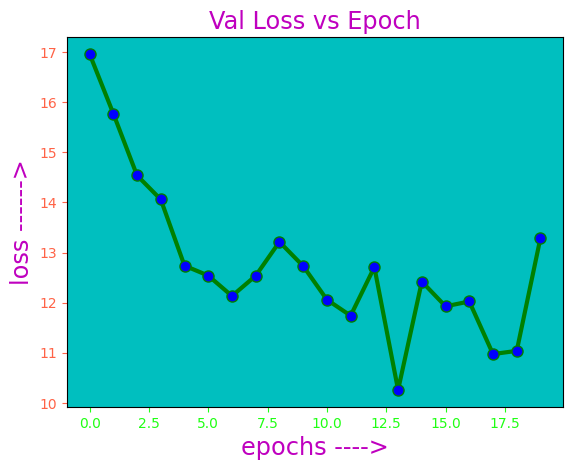

In [14]:
train(dataset,valdataset, model)

In [16]:
# Saving labels to label value as a json
main_dir = os.listdir(os.path.join("dataset","train"))
reference = {}
for i,dir in enumerate(main_dir):
    reference[dir]=i
with open('labels.json', 'wb') as iw:
    pickle.dump(reference, iw)

In [17]:
#Save the trained model
torch.save(model.state_dict(), "model.pth")

In [18]:
# prediction function to test
def predict(img_path):
    image = Image.open(img_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((256,256))])
    y_result = model(resize(image).unsqueeze(0))
    result_idx = y_result.argmax(dim=1)
    for key,value in reference.items():
        if(value==result_idx):
            print(key)
            break

In [20]:
predict("/content/dataset/test/PotatoHealthy1.JPG")

Potato___healthy


In [21]:
predict("/content/dataset/test/TomatoEarlyBlight2.JPG")

Tomato___Early_blight
